# A World Cup model

Here is a first model which uses historic international match data to predict the results of individual games, and then uses simulation to predict the winner of the World Cup. This model was built by Sorin Peste and you can find the original at [his Github repository](https://github.com/neaorin/PredictTheWorldCup). With Sorin's permission, we have reproduced the model that he built in R in Python, as well as updating the data on which it was based (thanks to Sam for scraping the FIFA website for this).

We're going to be building a random forest regressor to predict the goal difference in a game between any two teams participating in the World Cup. You haven't learned about random forests yet, but will in the next day or two. For now, all you need to know is that random forests are an ensemble method consisting of a number of decision trees, which minimise the well-known problem of high variance for individual trees and which can be used for either classification or regression problems. We're going to use the mean and variance of the predictions of each of the underlying trees in the forest as the basis for our simulations, as will be shown and described later.

So let's dive in, starting with the necessary imports.

In [1]:
import pandas as pd
from collections import namedtuple
from itertools import chain, groupby
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math
from collections import namedtuple
from itertools import chain, groupby, combinations
import psycopg2

In [2]:
pd.options.mode.chained_assignment = None 

## Data

The data consists of over 13,000 competitive international matches from 1956 to 2017, scraped from the FIFA website. We read in the data, drop some club matches which have snuck in there, do a bit of manipulation, create a couple of extra features and look at some features of the data

#### **Important note**

The datasets used in this train is the same datasets that is in your FIFA World Cup database that you launched on an Amazon RDS instance.

**Pro tip:** For machine learning purposes, its better to not have third normalised data! Although, they are awesome for building dashboards

### Connect to the Amazon RDS database

RDS Settings:

In [1]:
# Do not change
rds_endpoint = 'edsasoccerinstance.cnzbp4ndrpos.eu-west-1.rds.amazonaws.com'
rds_user = 'edsaSoccer'
rds_psswrd = 'edsaSoccer'
port = 5432
rds_database = 'edsaWorldCupPrediction'

Run function to connect to the database:

In [3]:
try:
    conn = psycopg2.connect("dbname='{:s}' user='{:s}' host='{:s}' password='{:s}'".format(rds_database, rds_user, rds_endpoint, rds_psswrd))
    print("Connected to the database")
except:
    print("Unable to connect to the database, please check your settings")

Unable to connect to the database, please check your settings


In [5]:
matches = pd.read_sql_query("SELECT * FROM matches", con=conn)

In [6]:
# venue is missing (new FIFA website doesn't carry it) so remove the field
# note: this means that the home/away analysis carried out by Soren in R can't be replicated in Python
print('Number of records in database: {}'.format(matches.shape[0]))
print('Number of records missing venue: {}'.format(matches['venue'].isnull().sum().sum()))
matches.drop('venue',axis=1,inplace=True)

Number of records in database: 13174
Number of records missing venue: 13174


In [7]:
# no duplicate rows in the new database, so no need to drop
matches.duplicated().sum()

0

In [8]:
# convert date strings to datetime objects and create 'year' field
matches.loc[:,'date'] = pd.to_datetime(matches.loc[:,'date'].astype(str), format='%Y-%m-%d')
matches['year'] = [x.year for x in matches['date']]

In [9]:
# friendlies have already been removed from the dataset when scraping
# (as have futsal, age group tournaments, club games and youth Olympics)
# so no need for a friendly indicator, nor to later remove friendlies
# however, there are club games in there which need to be removed

# indicators for type of game
matches.drop(matches[[bool(re.compile(r'Club').search(x)) for x in matches['CupName']]].index,inplace=True)
matches['qualifier'] = [bool(re.compile(r'Prel|Qual').search(x)) for x in matches['CupName']]
matches['finaltourn'] = [not x for x in matches['qualifier']]

matches.head()

,date,team1,team1Text,team2,team2Text,IdCupSeason,CupName,team1Score,team2Score,statText,resText,team1PenScore,team2PenScore,year,qualifier,finaltourn
0,1956-09-30,AUT,Austria,LUX,Luxembourg,10,FIFA WC 1958 Prel. Comp. UEFA,7,0,None,7-0,NaN,NaN,1956,True,False
1,1956-10-03,IRL,Republic of Ireland,DEN,Denmark,10,FIFA WC 1958 Prel. Comp. UEFA,2,1,None,2-1,NaN,NaN,1956,True,False
2,1956-11-11,FRA,France,BEL,Belgium,10,FIFA WC 1958 Prel. Comp. UEFA,6,3,None,6-3,NaN,NaN,1956,True,False
3,1956-12-05,ENG,England,DEN,Denmark,10,FIFA WC 1958 Prel. Comp. UEFA,5,2,None,5-2,NaN,NaN,1956,True,False
4,1956-11-24,URS,Soviet Union,FRG,Germany FR,197067,Olympic Football Tournament Melbourne 1956,2,1,None,2-1,NaN,NaN,1956,False,True


In [10]:
matches.shape

(13153, 16)

In [11]:
# add match ID
matches.sort_values('date',inplace=True)
matches['match_id'] = range(0,matches.shape[0])

In [12]:
matches.describe()

,IdCupSeason,team1Score,team2Score,team1PenScore,team2PenScore,year,match_id
count,13153.000000,13153.000000,13153.000000,169.000000,169.000000,13153.000000,13153.00000
mean,87943.744469,1.746522,1.106820,3.964497,3.970414,1996.426519,6576.00000
std,119187.388985,1.770623,1.375813,1.914523,1.888014,14.562949,3797.08838
min,10.000000,0.000000,0.000000,0.000000,0.000000,1956.000000,0.00000
25%,895.000000,1.000000,0.000000,3.000000,3.000000,1988.000000,3288.00000
50%,3881.000000,1.000000,1.000000,4.000000,4.000000,2000.000000,6576.00000
75%,250358.000000,2.000000,2.000000,5.000000,5.000000,2007.000000,9864.00000
max,277926.000000,31.000000,22.000000,13.000000,12.000000,2017.000000,13152.00000


Let's have a look at the average number of goals scored per game over time. We can see that the high-scoring goal fests of the 50s and 60s have more or less disappeared, thanks mainly to the introduction of improved defensive structures such as the catenaccio system of the Italians from the 70s.

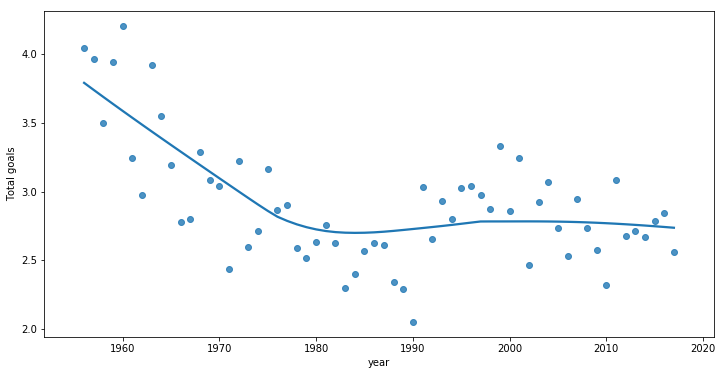

In [13]:
# goals scored per game, over time
plt.figure(figsize=(12,6))
matches['Total goals'] = [x + y for x,y in zip(matches['team1Score'],matches['team2Score'])] 
goals_per_match = matches.pivot_table(index='year',values='Total goals',aggfunc=np.mean).reset_index()
#goals_per_match
sns.regplot(x='year', y='Total goals', data=goals_per_match, lowess=True)

We unfortunately don't have venue data on the new FIFA website, but typically team1 is the home team unless the game was played in a neutral venue. If we look at the goal difference, defined as team1Score minus team2Score, we can see that it's been on average about 0.64.

In [14]:
pd.DataFrame([x - y for x,y in zip(matches['team1Score'],matches['team2Score'])]).describe()

,0
count,13153.000000
mean,0.639702
std,2.449079
min,-22.000000
25%,-1.000000
50%,1.000000
75%,2.000000
max,31.000000


Since World Cup matches are played on neutral territory (unless you're Russia), we want to avoid building in a bias towards team1 in our machine learning algorithm, so we randomly swap the order for roughly half of the observations:

In [15]:
# randomly reallocate team1 and team2 to avoid ML algorithm locking onto team1 win as a feature
np.random.seed(4342)
n = matches.shape[0]
matches['switch'] = np.random.uniform(0,1,n)
matches1 = matches[matches['switch']<=0.5]
matches2 = matches[matches['switch']>0.5]
matches2[['team1','team2']] = matches2[['team2','team1']]
matches2[['team1Text','team2Text']] = matches2[['team2Text','team1Text']]
matches2[['team1Score','team2Score']] = matches2[['team2Score','team1Score']]
matches2[['team1PenScore','team2PenScore']] = matches2[['team2PenScore','team1PenScore']]
matches = matches1.append(matches2)
pd.DataFrame([x - y for x,y in zip(matches['team1Score'],matches['team2Score'])]).describe()

,0
count,13153.000000
mean,0.019463
std,2.531178
min,-31.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,22.000000


In order to do our feature engineering, we want to be able to extract all match data involving a particular team. One way to do this is to double up the data set, swapping team1 and team2 in the second half, so that we can get what we're looking for simply by grouping on team1.

In [16]:
# team performance
matches1 = matches[['match_id','date','team1','team2','team1Score','team2Score','year','Total goals','qualifier','finaltourn']]
matches2 = matches1.copy()
matches2[['team2','team1']] = matches2[['team1','team2']]
matches2[['team2Score','team1Score']] = matches2[['team1Score','team2Score']]

teamperf = pd.concat([matches1,matches2])
teamperf['gd'] = [x-y for x,y in zip(teamperf['team1Score'],teamperf['team2Score'])]
teamperf['w'] = [(x>y) for x,y in zip(teamperf['team1Score'],teamperf['team2Score'])]
teamperf['l'] = [(x<y) for x,y in zip(teamperf['team1Score'],teamperf['team2Score'])]
teamperf['d'] = [(x==y) for x,y in zip(teamperf['team1Score'],teamperf['team2Score'])]

teamperf.sort_values('date',ascending=True,inplace=True)
teamperf.head()

,match_id,date,team1,team2,team1Score,team2Score,year,Total goals,qualifier,finaltourn,gd,w,l,d
30,0,1956-01-21,URU,PAR,4,2,1956,6,False,True,2,True,False,False
30,0,1956-01-21,PAR,URU,2,4,1956,6,False,True,-2,False,True,False
31,1,1956-01-22,ARG,PER,2,1,1956,3,False,True,1,True,False,False
31,1,1956-01-22,PER,ARG,1,2,1956,3,False,True,-1,False,True,False
32,2,1956-01-24,CHI,BRA,4,1,1956,5,False,True,3,True,False,False


Now let's use our modified data set to see which teams have the best winning records over time. To avoid noise, we impose the requirement that a minimum of 100 games must have been played.

In [17]:
# Out of the teams who have played at least 100 games, what are the winning percentages for each of those teams?

def formula_winpercentage(totalgames, wins, draws):
    return ((wins + 0.5 * draws) / totalgames)

team_wld = teamperf.groupby('team1').sum()[['w','l','d']].reset_index()
team_wld['games'] = [a+b+c for a,b,c in zip(team_wld['w'],team_wld['l'],team_wld['d'])]
team_wld = team_wld[team_wld['games'] >= 100]
team_wld['winpercentage'] = [formula_winpercentage(x,y,z) for x,y,z in zip(team_wld['games'],team_wld['w'],team_wld['d'])]
team_wld.sort_values(by='winpercentage',ascending=False).head()

,team1,w,l,d,games,winpercentage
76,GER,112.0,29.0,33.0,174.0,0.738506
69,FRG,85.0,23.0,30.0,138.0,0.724638
29,BRA,274.0,76.0,96.0,446.0,0.721973
207,URS,91.0,28.0,26.0,145.0,0.717241
63,ESP,170.0,53.0,68.0,291.0,0.701031


So Germany have won 74% of their games, Brazil 72% and Spain 70%... no big surprises there. But who are FRG and URS? It turns out that these are countries that don't exist any more, thanks to shifting geopolitics: FRG is the old West Germany, and URS the old USSR. So we have to find a mapping of these old country codes onto their modern equivalents, which requires some judgement in some cases: for example, Yugoslavia (SCG) has been mapped onto Serbia, but could just as easily have been mapped onto one of the other countries that emerged from that conflict. West Germany maps to Germany, Czechoslovakia to the Czech Republic, USSR to Russia and Zaire to the DRC.

In [18]:
def countryMapping(row):
    if row == 'FRG':
        val = 'GER'
    elif row == 'TCH':
        val = 'CZE'
    elif row == 'URS':
        val = 'RUS'
    elif row == 'SCG':
        val = 'SRB'
    elif row == 'ZAI':
        val = 'COD'
    else:
        val = row
    return val

In [19]:
teamperf['team1'] = teamperf['team1'].apply(lambda x: countryMapping(x))
teamperf['team2'] = teamperf['team2'].apply(lambda x: countryMapping(x))

matches['team1'] = matches['team1'].apply(lambda x: countryMapping(x))
matches['team2'] = matches['team2'].apply(lambda x: countryMapping(x))

In [20]:
team_wld = teamperf.groupby('team1').sum()[['w','l','d']].reset_index()
team_wld.loc[:,'games'] = [a+b+c for a,b,c in zip(team_wld['w'],team_wld['l'],team_wld['d'])]
team_wld = team_wld[team_wld['games'] >= 100]
team_wld.loc[:,'winpercentage'] = [formula_winpercentage(x,y,z) for x,y,z in zip(team_wld['games'],team_wld['w'],team_wld['d'])]
team_wld.sort_values(by='winpercentage',ascending=False).head()

,team1,w,l,d,games,winpercentage
75,GER,197.0,52.0,63.0,312.0,0.732372
29,BRA,274.0,76.0,96.0,446.0,0.721973
63,ESP,170.0,53.0,68.0,291.0,0.701031
96,ITA,179.0,54.0,90.0,323.0,0.693498
60,ENG,125.0,39.0,65.0,229.0,0.687773


Let's have a look now at the distribution of scorelines and goals scored.

In [21]:
scores = matches[['team1Score','team2Score']]
scores.head()

,team1Score,team2Score
30,4,2
31,2,1
32,4,1
35,0,0
37,2,1


In [22]:
# what is the occurrence frequency for match scores?
scores1 = matches[matches['team1Score']>=matches['team2Score']]
scores2 = matches[matches['team2Score']>matches['team1Score']]
scores2[['team1Score','team2Score']] = scores2[['team2Score','team1Score']]
scores = pd.concat([scores1,scores2])[['team1Score','team2Score']]
scorefreq = scores.groupby(['team1Score','team2Score']).size().reset_index()
scorefreq.columns.values[2] = 'Number'
scorefreq.sort_values('Number',ascending=False).head(15)

,team1Score,team2Score,Number
1,1,0,2312
3,2,0,1709
4,2,1,1646
2,1,1,1275
0,0,0,1111
6,3,0,1026
7,3,1,755
10,4,0,575
5,2,2,446
8,3,2,394


So it's official... 1-0 is the most common scoreline in international football!

C:\Users\yevashan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\__init__.py:1855: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


Text(0.5,1,'Distribution of goals scored per game')

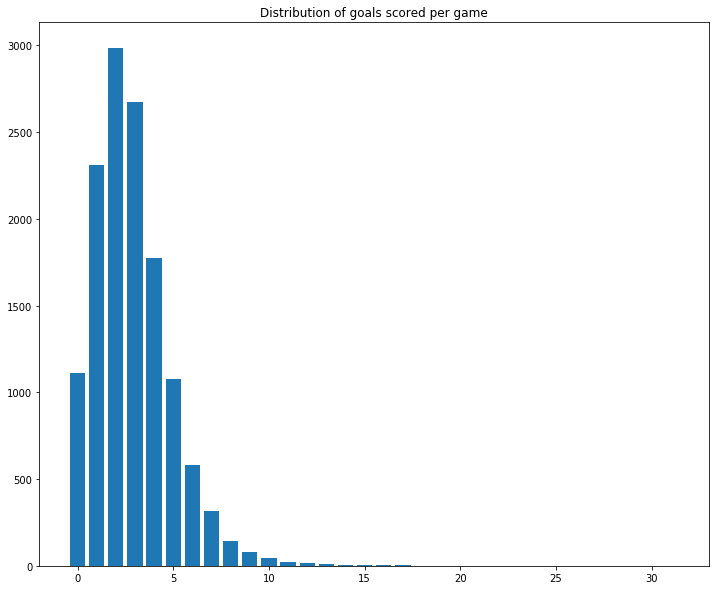

In [23]:
matches['gs'] = [(x+y) for x,y in zip(matches['team1Score'],matches['team2Score'])] 
gsfreq = matches.groupby('gs').size().reset_index()
gsfreq.columns.values[1] = 'Freq'
plt.figure(figsize=(12,10))
plt.bar(left='gs',height='Freq',data=gsfreq)
plt.title('Distribution of goals scored per game')

C:\Users\yevashan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\__init__.py:1855: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


Text(0.5,1,'Distribution of goal difference (-4 to +4)')

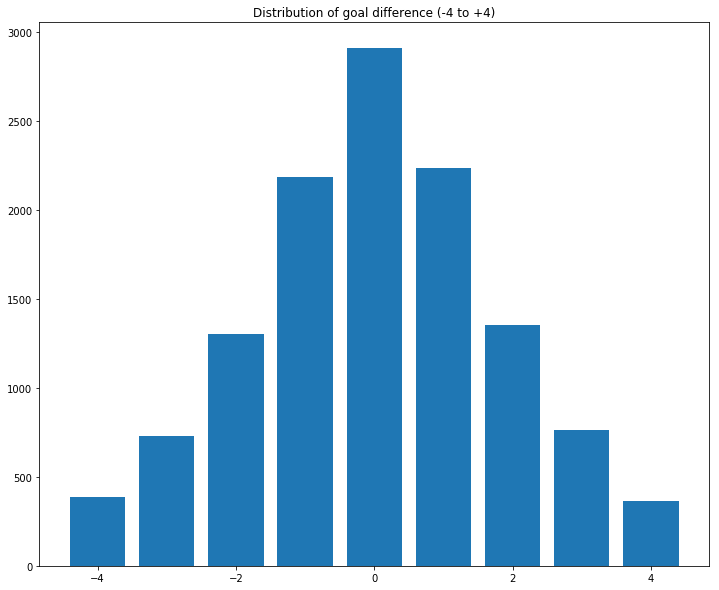

In [24]:
matches['gd'] = [(x-y) for x,y in zip(matches['team1Score'],matches['team2Score'])] 
gdfreq = matches.groupby('gd').size().reset_index()
gdfreq.columns.values[1] = 'Freq'
plt.figure(figsize=(12,10))
plt.bar(left='gd',height='Freq',data=gdfreq[abs(gdfreq['gd'])<=4].reset_index())
plt.title('Distribution of goal difference (-4 to +4)')

C:\Users\yevashan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\__init__.py:1855: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


Text(0.5,1,'Distribution of absoluted goald difference')

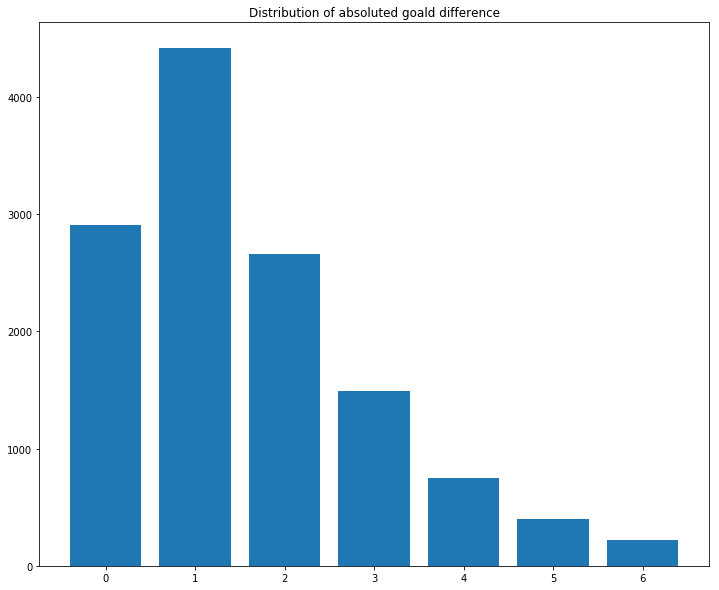

In [25]:
matches['abs_gd'] = [abs(x-y) for x,y in zip(matches['team1Score'],matches['team2Score'])] 
absgdfreq = matches.groupby('abs_gd').size().reset_index()
absgdfreq.columns.values[1] = 'Freq'
plt.figure(figsize=(12,10))
plt.bar(left='abs_gd',height='Freq',data=absgdfreq[absgdfreq['abs_gd']<=6].reset_index())
plt.title('Distribution of absoluted goald difference')

### Outliers

In [26]:
# how many outliers do we have?
temp = matches[matches['gd']>7]
temp.head()
print('{} matches, or {:0.2f}% of total, are outliers with gd>7.'.format(temp.shape[0],temp.shape[0]/matches.shape[0]*100))

104 matches, or 0.79% of total, are outliers with gd>7.


In [27]:
#get rid of outliers by capping absolute gd to 7
teamperf.loc[teamperf['gd']>7,'gd'] = 7
teamperf.loc[teamperf['gd']<-7,'gd'] = -7

### Strength of opposition

Obviously, things can be a little misleading because teams tend to play most of their games against other teams in the same confederation (e.g. South American teams play mostly against other South American teams). So we need to bring in an indicator of the strength of the opposition. Fortunately Fifa have a confederation adjustment factor which they take into account in their own ranking system, so that's what we'll use.

Let's read one of the tables into a dataframe:

In [28]:
teams = pd.read_sql_query("SELECT * FROM teams", con=conn)

In [29]:
#check for duplicate FIFA codes
print(teams.loc[teams.duplicated('fifa_code'),'fifa_code'])

# some missing codes --- which can be ignored, but AUS is duplicated; investigate further:
print(teams[teams['fifa_code']=='AUS'])

# AUS is allocated to AFC and OFC. It's part of Oceania, so drop the AFC record
teams.drop(teams[(teams['fifa_code']=='AUS') & (teams['confederation']=='AFC')].index,inplace=True)
teams.shape

137    ---
156    ---
194    AUS
197    ---
198    ---
199    ---
200    ---
201    ---
204    ---
210    ---
Name: fifa_code, dtype: object
    confederation       name fifa_code ioc_code
55            AFC  Australia       AUS      ---
194           OFC  Australia       AUS      AUS


(221, 4)

In [30]:
# set up a dataframe of the FIFA confederation adjustment factors
confederations = pd.DataFrame({'confederation':['UEFA','CONMEBOL','CONCACAF','AFC','CAF','OFC'],
                               'adjust':[0.99,1,0.85,0.85,0.85,0.85]})

# add opposition (team2) adjustment factor to teamperf
teamperf = pd.merge(teamperf,teams,left_on=['team2'],right_on=['fifa_code'],how='left')
teamperf.drop(['name','fifa_code','ioc_code'],axis=1,inplace=True)
teamperf = pd.merge(teamperf,confederations,how='left',on='confederation')
teamperf['adjust'].fillna(1,inplace=True)
teamperf.head(10)

,match_id,date,team1,team2,team1Score,team2Score,year,Total goals,qualifier,finaltourn,gd,w,l,d,confederation,adjust
0,0,1956-01-21,URU,PAR,4,2,1956,6,False,True,2,True,False,False,CONMEBOL,1.0
1,0,1956-01-21,PAR,URU,2,4,1956,6,False,True,-2,False,True,False,CONMEBOL,1.0
2,1,1956-01-22,ARG,PER,2,1,1956,3,False,True,1,True,False,False,CONMEBOL,1.0
3,1,1956-01-22,PER,ARG,1,2,1956,3,False,True,-1,False,True,False,CONMEBOL,1.0
4,2,1956-01-24,CHI,BRA,4,1,1956,5,False,True,3,True,False,False,CONMEBOL,1.0
5,2,1956-01-24,BRA,CHI,1,4,1956,5,False,True,-3,False,True,False,CONMEBOL,1.0
6,3,1956-01-28,PER,URU,0,2,1956,2,False,True,-2,False,True,False,CONMEBOL,1.0
7,3,1956-01-28,URU,PER,2,0,1956,2,False,True,2,True,False,False,CONMEBOL,1.0
8,5,1956-01-29,CHI,ARG,0,2,1956,2,False,True,-2,False,True,False,CONMEBOL,1.0
9,4,1956-01-29,BRA,PAR,0,0,1956,0,False,True,0,False,False,True,CONMEBOL,1.0


## Feature engineering

The features we're going to use for our machine learning are lag features that give us some indication of the short-, medium- and longer-term form of each team. We'll look at the percentage of games that have been won, drawn and lost respectively in the preceding 10, 30 or 50 games for each team, as well as a measure of opposition strength over these periods using the FIFA confederation adjustment factors for their opponents.

In [31]:
# Let's calculate some lag features for each team which is about to play a game
# we'll take three windows: last 10 games, last 30 games, last 50 games.
# For each window we'll calculate some values.

team_features = teamperf.copy()

team_features.sort_values(['team1','date'],inplace=True)
for col in ['last10games_win_per','last10games_loss_per','last10games_draw_per','last10games_gd_avg','last10games_opp_cc_per',
            'last30games_win_per','last30games_loss_per','last30games_draw_per','last30games_gd_avg','last30games_opp_cc_per',
            'last50games_win_per','last50games_loss_per','last50games_draw_per','last50games_gd_avg','last50games_opp_cc_per']:
    team_features[col] = 0

In [32]:
# Missing values won't be accommodated by sklearn algorithms, so we either need to define some
# missing value handling approach or ensure that there is no missing data in our features.
# Here we avoid missing values by allowing features to be calculated over whatever history is available,
# if it is less than 10/30/50 games.

teamnames = set(teamperf['team1'])

for team in teamnames:
    subset = team_features[team_features['team1']==team]

    games_last10 = subset['w'].rolling(10,min_periods=1).count()
    wins_last10 = subset['w'].rolling(10,min_periods=1).sum()/games_last10
    draws_last10 = subset['d'].rolling(10,min_periods=1).sum()/games_last10
    losses_last10 = subset['l'].rolling(10,min_periods=1).sum()/games_last10
    gd_last10 = subset['gd'].rolling(10,min_periods=1).sum()/games_last10
    cc_opp_last10 = subset['adjust'].rolling(10,min_periods=1).sum()/games_last10
    team_features.loc[team_features['team1']==team,'last10games_win_per'] = wins_last10
    team_features.loc[team_features['team1']==team,'last10games_loss_per'] = losses_last10
    team_features.loc[team_features['team1']==team,'last10games_draw_per'] = draws_last10
    team_features.loc[team_features['team1']==team,'last10games_gd_avg'] = gd_last10
    team_features.loc[team_features['team1']==team,'last10games_opp_cc_per'] = cc_opp_last10

    games_last30 = subset['w'].rolling(30,min_periods=1).count()
    wins_last30 = subset['w'].rolling(30,min_periods=1).sum()/games_last30
    draws_last30 = subset['d'].rolling(30,min_periods=1).sum()/games_last30
    losses_last30 = subset['l'].rolling(30,min_periods=1).sum()/games_last30
    gd_last30 = subset['gd'].rolling(30,min_periods=1).sum()/games_last30
    cc_opp_last30 = subset['adjust'].rolling(30,min_periods=1).sum()/games_last30
    team_features.loc[team_features['team1']==team,'last30games_win_per'] = wins_last30
    team_features.loc[team_features['team1']==team,'last30games_loss_per'] = losses_last30
    team_features.loc[team_features['team1']==team,'last30games_draw_per'] = draws_last30
    team_features.loc[team_features['team1']==team,'last30games_gd_avg'] = gd_last30
    team_features.loc[team_features['team1']==team,'last30games_opp_cc_per'] = cc_opp_last30
    
    games_last50 = subset['w'].rolling(50,min_periods=1).count()
    wins_last50 = subset['w'].rolling(50,min_periods=1).sum()/games_last50
    draws_last50 = subset['d'].rolling(50,min_periods=1).sum()/games_last50
    losses_last50 = subset['l'].rolling(50,min_periods=1).sum()/games_last50
    gd_last50 = subset['gd'].rolling(50,min_periods=1).sum()/games_last50
    cc_opp_last50 = subset['adjust'].rolling(50,min_periods=1).sum()/games_last50
    team_features.loc[team_features['team1']==team,'last50games_win_per'] = wins_last50
    team_features.loc[team_features['team1']==team,'last50games_loss_per'] = losses_last50
    team_features.loc[team_features['team1']==team,'last50games_draw_per'] = draws_last50
    team_features.loc[team_features['team1']==team,'last50games_gd_avg'] = gd_last50
    team_features.loc[team_features['team1']==team,'last50games_opp_cc_per'] = cc_opp_last50

In [33]:
# let's see what this looks like for Brazil in 1970
pd.options.display.max_columns = team_features.shape[1]
team_features[(team_features['team1']=='BRA') & (team_features['date']>='1970-01-01')].head()

,match_id,date,team1,team2,team1Score,team2Score,year,Total goals,qualifier,finaltourn,gd,w,l,d,confederation,adjust,last10games_win_per,last10games_loss_per,last10games_draw_per,last10games_gd_avg,last10games_opp_cc_per,last30games_win_per,last30games_loss_per,last30games_draw_per,last30games_gd_avg,last30games_opp_cc_per,last50games_win_per,last50games_loss_per,last50games_draw_per,last50games_gd_avg,last50games_opp_cc_per
1920,958,1970-06-03,BRA,CZE,4,1,1970,5,False,True,3,True,False,False,UEFA,0.99,0.7,0.1,0.2,2.3,0.968,0.566667,0.266667,0.166667,1.166667,0.971333,0.60,0.22,0.18,1.06,0.9816
1936,967,1970-06-07,BRA,ENG,1,0,1970,1,False,True,1,True,False,False,UEFA,0.99,0.8,0.0,0.2,2.5,0.968,0.566667,0.266667,0.166667,1.033333,0.971000,0.62,0.20,0.18,1.14,0.9814
1938,969,1970-06-10,BRA,ROU,3,2,1970,5,False,True,1,True,False,False,UEFA,0.99,0.9,0.0,0.1,2.6,0.982,0.600000,0.233333,0.166667,1.133333,0.971000,0.64,0.20,0.16,1.16,0.9812
1960,979,1970-06-14,BRA,PER,4,2,1970,6,False,True,2,True,False,False,CONMEBOL,1.00,1.0,0.0,0.0,2.8,0.997,0.600000,0.233333,0.166667,1.133333,0.976000,0.64,0.20,0.16,1.18,0.9812
1965,982,1970-06-17,BRA,URU,3,1,1970,4,False,True,2,True,False,False,CONMEBOL,1.00,1.0,0.0,0.0,2.8,0.997,0.633333,0.233333,0.133333,1.200000,0.976333,0.64,0.20,0.16,1.16,0.9814


In [34]:
team_features.columns

Index(['match_id', 'date', 'team1', 'team2', 'team1Score', 'team2Score',
       'year', 'Total goals', 'qualifier', 'finaltourn', 'gd', 'w', 'l', 'd',
       'confederation', 'adjust', 'last10games_win_per',
       'last10games_loss_per', 'last10games_draw_per', 'last10games_gd_avg',
       'last10games_opp_cc_per', 'last30games_win_per', 'last30games_loss_per',
       'last30games_draw_per', 'last30games_gd_avg', 'last30games_opp_cc_per',
       'last50games_win_per', 'last50games_loss_per', 'last50games_draw_per',
       'last50games_gd_avg', 'last50games_opp_cc_per'],
      dtype='object')

In [35]:
# fold per-team features into per-match features

# drop fields no longer needed
team_features.drop(['team1Score','team2Score','Total goals','w','l','d','confederation',
                    'adjust'],axis=1,inplace=True)

In [36]:
# create second data frame for joining excluding fields that we only want once
team_features_reduced = team_features.copy()
team_features_reduced.drop(['date','year','qualifier','finaltourn'],axis=1,inplace=True)

# merge data frames
match_features = pd.merge(matches[['match_id','team1']],team_features,on=['match_id','team1'])
match_features = pd.merge(match_features,team_features_reduced,left_on=['match_id','team2'],right_on=['match_id','team1'])

In [37]:
# edit data frame
match_features.drop(['team1_y','team2_y','gd_y'],axis=1,inplace=True)
match_features.rename(columns = {'team1_x':'team1','team2_x':'team2','gd_x':'outcome'}, inplace = True)
match_features.head()

,match_id,team1,date,team2,year,qualifier,finaltourn,outcome,last10games_win_per_x,last10games_loss_per_x,last10games_draw_per_x,last10games_gd_avg_x,last10games_opp_cc_per_x,last30games_win_per_x,last30games_loss_per_x,...,last10games_win_per_y,last10games_loss_per_y,last10games_draw_per_y,last10games_gd_avg_y,last10games_opp_cc_per_y,last30games_win_per_y,last30games_loss_per_y,last30games_draw_per_y,last30games_gd_avg_y,last30games_opp_cc_per_y,last50games_win_per_y,last50games_loss_per_y,last50games_draw_per_y,last50games_gd_avg_y,last50games_opp_cc_per_y
0,0,URU,1956-01-21,PAR,1956,False,True,2,1.000000,0.000000,0.000000,2.000000,1.0,1.000000,0.000000,...,0.0,1.0,0.0,-2.000000,1.0,0.0,1.0,0.0,-2.000000,1.0,0.0,1.0,0.0,-2.000000,1.0
1,1,ARG,1956-01-22,PER,1956,False,True,1,1.000000,0.000000,0.000000,1.000000,1.0,1.000000,0.000000,...,0.0,1.0,0.0,-1.000000,1.0,0.0,1.0,0.0,-1.000000,1.0,0.0,1.0,0.0,-1.000000,1.0
2,2,CHI,1956-01-24,BRA,1956,False,True,3,1.000000,0.000000,0.000000,3.000000,1.0,1.000000,0.000000,...,0.0,1.0,0.0,-3.000000,1.0,0.0,1.0,0.0,-3.000000,1.0,0.0,1.0,0.0,-3.000000,1.0
3,4,BRA,1956-01-29,PAR,1956,False,True,0,0.000000,0.500000,0.500000,-1.500000,1.0,0.000000,0.500000,...,0.0,0.5,0.5,-1.000000,1.0,0.0,0.5,0.5,-1.000000,1.0,0.0,0.5,0.5,-1.000000,1.0
4,6,BRA,1956-02-01,PER,1956,False,True,1,0.333333,0.333333,0.333333,-0.666667,1.0,0.333333,0.333333,...,0.0,1.0,0.0,-1.333333,1.0,0.0,1.0,0.0,-1.333333,1.0,0.0,1.0,0.0,-1.333333,1.0


Let's have a peek at correlation between our numeric features.

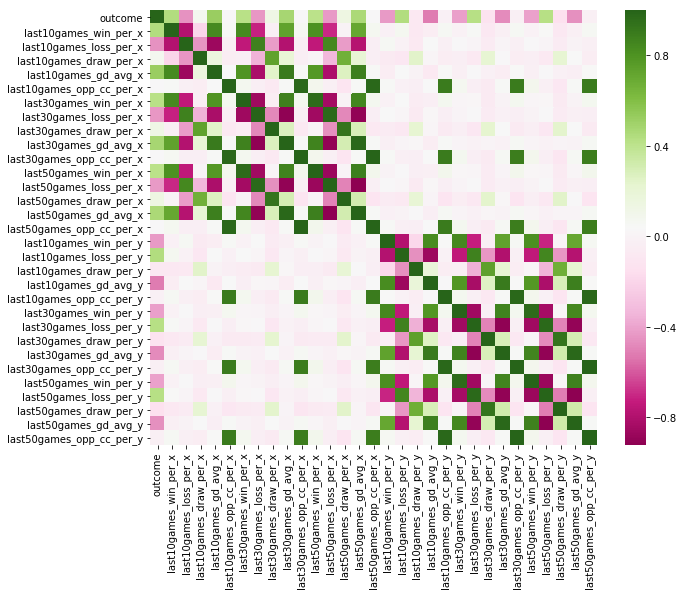

In [38]:
cor = match_features.drop(['match_id','date','team1','team2','year','qualifier','finaltourn'],axis=1).corr()
plt.figure(figsize=(10,8))
sns.set_palette("husl")
sns.heatmap(cor, 
            xticklabels=cor.columns.values,
            yticklabels=cor.columns.values,
            cmap='PiYG')

It looks like outcomes are correlated with our lag features, and that lag features for team1 have low correlation with those for team2. No major surprises here, but good confirmation that we have a set of features that may help us with predictions. And no individual feature has much stronger correlation than all others.

## Training a random forest

We could train a classification algorithm, where the target variable is one of the three categories win, lose or draw, but it's more useful for the purpose of simulating World Cup winners to train a regression algorithm on goal difference (have a think about why). There are a variety of appraoches we could take, such as:

* linear regression

* neural network regression

* decision tree regression

* boosted decision tree regression

But we're going to train a random forest, which grows multiple decision trees and has each individual tree "vote" on the outcome for each new input vector (or in other words, new match to predict). It's fast, fairly accurate, and it gives an unbiased estimate of the generalization error. You'll be learning more about random forests in the next day or two if you haven't already.

We're going to tell the algorithm to grow 500 trees.

First, we'll do a train-test split by training on pre-2009 match results and seeing how our model performs on post-2009 results.

In [39]:
data_train = match_features[match_features['date']<'2009-01-01']
data_test = match_features[match_features['date']>='2009-01-01']

X_train = data_train.drop(['outcome','match_id','date','team1','team2','year'],axis=1)
y_train = data_train['outcome']
X_test = data_test.drop(['outcome','match_id','date','team1','team2','year'],axis=1)
y_test = data_test['outcome']

In [40]:
WC_rf = RandomForestRegressor(n_estimators=500)

In [41]:
WC_rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

We can then produce a variable importance graph to show which features turn out to be the most predictive of match outcomes. We can see below that the average goal difference for both teams over their past 10 games are by some margin the most important features.

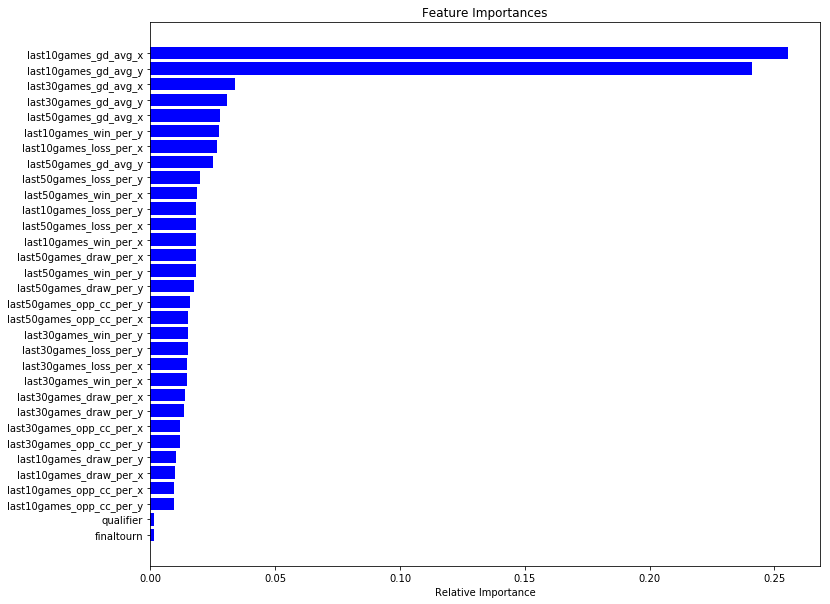

In [42]:
features = X_train.columns
importance = WC_rf.feature_importances_
indices = np.argsort(importance)

plt.figure(figsize=(12,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

Let's then predict outcomes on our test set, and see how well we do (measured by root mean squared error).

In [43]:
pred = WC_rf.predict(X_test)

In [44]:
from sklearn.metrics import mean_squared_error
print('Root mean squared error on test data is {:0.5f}.'.format(math.sqrt(mean_squared_error(y_test,pred))))

Root mean squared error on test data is 1.57844.


## Head to head of all combinations of qualifiers

For performance reasons, it makes sense to extract key parameters for our simulation model by looking at all possible head-to-head match-ups at the World Cup. We start by reading in data of all teams with their group draws.

In [45]:
#read in qualified teams with group allocation
teams = pd.read_sql_query("SELECT * FROM wc2018qualified", con=conn)

In [46]:
teams.head(12)

,name,draw
0,RUS,A1
1,KSA,A2
2,EGY,A3
3,URU,A4
4,POR,B1
5,ESP,B2
6,MAR,B3
7,IRN,B4
8,FRA,C1
9,AUS,C2


In [47]:
# create a dataframe of all possible head-to-head match-ups
head_to_head = pd.DataFrame(list(combinations(teams['name'],2)))
head_to_head.rename(index=str,columns = {0:'team1',1:'team2'},inplace=True)
head_to_head.head()

,team1,team2
0,RUS,KSA
1,RUS,EGY
2,RUS,URU
3,RUS,POR
4,RUS,ESP


Now we create a dataframe of features for all of those possible encounters, based on form leading up to the World Cup.

In [48]:
# get latest record for each team
temp_x = match_features.loc[match_features.groupby('team1').date.idxmax(),:]
temp_x.drop(['match_id','date','team2','year','qualifier','finaltourn','outcome',
             'last10games_win_per_y','last10games_loss_per_y', 'last10games_draw_per_y',
             'last10games_gd_avg_y', 'last10games_opp_cc_per_y',
             'last30games_win_per_y', 'last30games_loss_per_y',
             'last30games_draw_per_y', 'last30games_gd_avg_y',
             'last30games_opp_cc_per_y', 'last50games_win_per_y',
             'last50games_loss_per_y', 'last50games_draw_per_y',
             'last50games_gd_avg_y', 'last50games_opp_cc_per_y'],axis=1,inplace=True)

temp_y = match_features.loc[match_features.groupby('team2').date.idxmax(),:]
temp_y.drop(['match_id','date','team1','year','qualifier','finaltourn','outcome',
             'last10games_win_per_x','last10games_loss_per_x', 'last10games_draw_per_x',
             'last10games_gd_avg_x', 'last10games_opp_cc_per_x',
             'last30games_win_per_x', 'last30games_loss_per_x',
             'last30games_draw_per_x', 'last30games_gd_avg_x',
             'last30games_opp_cc_per_x', 'last50games_win_per_x',
             'last50games_loss_per_x', 'last50games_draw_per_x',
             'last50games_gd_avg_x', 'last50games_opp_cc_per_x'],axis=1,inplace=True)

# join this with head to head encounters
temp = pd.merge(head_to_head,temp_x,on='team1',how='left')
pred_features = pd.merge(temp,temp_y,on='team2',how='left')
pred_features['qualifier'] = False
pred_features['finaltourn'] = True
pred_features.drop(['team1','team2'],axis=1,inplace=True)
pred_features = pred_features[X_test.columns]
pred_features.head()

,qualifier,finaltourn,last10games_win_per_x,last10games_loss_per_x,last10games_draw_per_x,last10games_gd_avg_x,last10games_opp_cc_per_x,last30games_win_per_x,last30games_loss_per_x,last30games_draw_per_x,last30games_gd_avg_x,last30games_opp_cc_per_x,last50games_win_per_x,last50games_loss_per_x,last50games_draw_per_x,...,last10games_win_per_y,last10games_loss_per_y,last10games_draw_per_y,last10games_gd_avg_y,last10games_opp_cc_per_y,last30games_win_per_y,last30games_loss_per_y,last30games_draw_per_y,last30games_gd_avg_y,last30games_opp_cc_per_y,last50games_win_per_y,last50games_loss_per_y,last50games_draw_per_y,last50games_gd_avg_y,last50games_opp_cc_per_y
0,False,True,0.3,0.3,0.4,0.6,0.962,0.533333,0.266667,0.2,0.933333,0.980667,0.56,0.24,0.2,...,0.5,0.3,0.2,0.6,0.850,0.433333,0.333333,0.233333,0.566667,0.860000,0.44,0.28,0.28,0.52,0.8560
1,False,True,0.3,0.3,0.4,0.6,0.962,0.533333,0.266667,0.2,0.933333,0.980667,0.56,0.24,0.2,...,0.7,0.1,0.2,1.0,0.850,0.733333,0.166667,0.100000,0.900000,0.859667,0.70,0.20,0.10,0.90,0.8616
2,False,True,0.3,0.3,0.4,0.6,0.962,0.533333,0.266667,0.2,0.933333,0.980667,0.56,0.24,0.2,...,0.4,0.3,0.3,0.3,1.000,0.433333,0.366667,0.200000,0.400000,0.969333,0.42,0.40,0.18,0.20,0.9692
3,False,True,0.3,0.3,0.4,0.6,0.962,0.533333,0.266667,0.2,0.933333,0.980667,0.56,0.24,0.2,...,0.8,0.0,0.2,1.8,0.949,0.633333,0.100000,0.266667,1.166667,0.958000,0.60,0.12,0.28,1.10,0.9654
4,False,True,0.3,0.3,0.4,0.6,0.962,0.533333,0.266667,0.2,0.933333,0.980667,0.56,0.24,0.2,...,0.8,0.1,0.1,2.8,0.990,0.666667,0.166667,0.166667,1.566667,0.972333,0.70,0.16,0.14,1.50,0.9686


In [49]:
# we can then predict the goal difference for each of these match-ups
# For a random forest, this is the mean of the underlying trees' predictions.
pred_h2h = WC_rf.predict(pred_features)

In [50]:
# In order to simulate, we want an indication of variance as well asexpected outcome,
# so we need to get the predictions of the individual trees in the random forest.

rf_mean = []
rf_sd = []

for h2h in range(pred_features.shape[0]):
    features = pred_features.loc[h2h,:].values.reshape((1,pred_features.shape[1]))
    per_tree_pred = [tree.predict(features) for tree in WC_rf.estimators_]
    rf_mean.append(np.mean(per_tree_pred))
    rf_sd.append(np.std(per_tree_pred))
    
head_to_head['outcome'] = rf_mean
head_to_head['sd'] = rf_sd
head_to_head.tail()

,team1,team2,outcome,sd
491,POL,COL,0.590,1.428951
492,POL,JPN,0.600,1.479189
493,SEN,COL,0.486,1.561347
494,SEN,JPN,0.122,1.405388
495,COL,JPN,-0.596,1.438327


Let's see what our model predicts if Argentina were to meet Brazil tomorrow.

In [51]:
temp = head_to_head[(head_to_head['team1'] == 'ARG') & (head_to_head['team2'] == 'BRA')]
temp

,team1,team2,outcome,sd
309,ARG,BRA,-1.636,1.765079


This suggests that we'd expect Brazil to win, by a winning margin of about 1.6 goals on average. But the standard deviation of that outcome is 1.77 goals, which reflects the underlying uncertainty of the outcome of the match. If we impose the assumption of a normal distribution and a threshold of 0.5 goals for either team to win, with any outcome between -0.5 and 0.5 implying a draw, then we could simulate 100 games between the two teams and look at how many of each possible outcome we would expect to see.

In [52]:
np.random.seed(4342)
draw_threshold = 0.5

temp2 = np.random.normal(loc=temp['outcome'],scale=temp['sd'],size=100)

print('ARG won {} out of 100.'.format(sum(temp2>=draw_threshold)))
print('BRA won {} out of 100.'.format(sum(temp2<=-draw_threshold)))
print('There were {} draws.'.format(sum((temp2>-draw_threshold) & (temp2<draw_threshold))))

ARG won 8 out of 100.
BRA won 83 out of 100.
There were 9 draws.


In [53]:
#save these parameters to a file for our simulation model to use
head_to_head.to_csv('wc2018staticPredictions.csv',index=False)

## Simulation model


OK, let's do some simulation now! The code below (written by Sorin) simulates the entire tournament 1000 times and records the tournament winner for each simulation.

In [54]:
# simulate the FIFA World cup 1000 times.

np.random.seed(101)

Match = namedtuple("Match", ['gameId', 'date', 'time', 'team1', 'team2', 'group'])
Prediction = namedtuple("Prediction", ['team1', 'team2', 'outcome', 'sd'])
Team = namedtuple("Team", ['name', 'draw'])
Result = namedtuple("Result", ['match', 'team1Score', 'team2Score'])
TeamResult = namedtuple("TeamResult", ['name', 'opponent', 'group', 'gs', 'ga'])
TeamRecord = namedtuple("TeamRecord", ['name', 'group', 'p', 'gs', 'ga', 'defeated'])

#Helper functions

def loadCsv(filepath, itemtype):
    with open(filepath, 'r') as csvfile:
        reader = csv.DictReader(csvfile, delimiter=',')
        return list(map(lambda row: itemtype(**row), reader))

def getActualGroupMatch(match, teams):
    return Match(gameId = match.gameId, date = match.date, time = match.time, group = match.group,
        team1 = next(team.name for team in teams if team.draw == match.team1),
        team2 = next(team.name for team in teams if team.draw == match.team2),       
        )

def getActualEliminationMatch(match, qualified):
    return Match(gameId = match.gameId, date = match.date, time = match.time, group = match.group,
        team1 = qualified[match.team1],
        team2 = qualified[match.team2],
        )

def getResult(match, predictions):
    allowtie = match.group != None 
    prediction = next(pred for pred in predictions \
        if (pred.team1 == match.team1 and pred.team2 == match.team2) or \
            (pred.team1 == match.team2 and pred.team2 == match.team1)) 
    reverse = prediction.team1 != match.team1
    goaldiff = np.random.normal(float(prediction.outcome), float(prediction.sd))
    reverse = reverse != (goaldiff < 0) 
    normgoaldiff = 0 if abs(goaldiff) <= draw_threshold \
        else 1 if abs(goaldiff) < 1 else round(abs(goaldiff))
    if not(allowtie) and normgoaldiff == 0:
        normgoaldiff = 1
    losergoals = round(abs(np.random.normal(0, 1)))
    return Result(match, losergoals, losergoals + normgoaldiff) if reverse \
        else Result(match, losergoals + normgoaldiff, losergoals)

def getTeamPerfFromResult(result):
    return [TeamResult(name=result.match.team1, opponent=result.match.team2, group=result.match.group, gs=result.team1Score, ga=result.team2Score),
    TeamResult(name=result.match.team2, opponent=result.match.team1, group=result.match.group, gs=result.team2Score, ga=result.team1Score)]

def getTeamRecord(name, teamResults):
    points = w = d = gs = ga = 0
    group = ''
    defeated = []
    for result in teamResults:
        group = result.group
        gs += result.gs
        ga += result.ga
        if result.gs > result.ga:
            w += 1
            defeated.append(result.opponent)
        elif result.gs == result.ga:
            d += 1
    return TeamRecord(name=name, group=group, p=3*w+d, gs=gs, ga=ga, defeated=defeated)

def runGroupStage(schedule, predictions, teams):
    groupschedule = list(map(lambda x: getActualGroupMatch(x, teams), filter(lambda x: x.group != None, schedule)))
    groupresults = list(map(lambda x: getResult(x, predictions), groupschedule))
    groupperfs = list(chain.from_iterable(map(getTeamPerfFromResult, groupresults)))
    records = []
    for k, g in groupby(sorted(groupperfs, key=lambda x: x.name), key=lambda x: x.name):
        records.append(getTeamRecord(k, g))
    qualified = {}
    for k, g in groupby(sorted(records, key=lambda x: x.group), key=lambda x: x.group):
        grouptable = sorted(g, key=lambda x: 1000000*x.p + 10000*(x.gs-x.ga) + 100*(x.gs), reverse=True)
        qualified['1' + k] = grouptable[0].name
        qualified['2' + k] = grouptable[1].name
    return qualified

def runEliminationRound(round, prevround, schedule, predictions):
    roundschedule = list(map(lambda x: getActualEliminationMatch(x, prevround), filter(lambda x: x.gameId.startswith('G'+round), schedule)))
    roundresults = list(map(lambda x: getResult(x, predictions), roundschedule))
    results = {}
    for result in roundresults:
        results['W' + result.match.gameId] = result.match.team1 if result.team1Score > result.team2Score \
            else result.match.team2
        results['L' + result.match.gameId] = result.match.team1 if result.team1Score < result.team2Score \
            else result.match.team2
    return results

In [55]:
# Download data from Amazon RDS and save as CSV
pd.read_sql_query("SELECT * FROM wc2018schedule", con=conn).to_csv('wc2018schedule.csv', index=False)
pd.read_sql_query("SELECT * FROM wc2018qualified", con=conn).to_csv('wc2018qualified.csv', index=False)

In [56]:
#main
schedule = loadCsv('wc2018schedule.csv',Match)
predictions = loadCsv('wc2018staticPredictions.csv', Prediction)
teams = loadCsv('wc2018qualified.csv', Team)
simresults = pd.DataFrame(columns=['iteration','winner'])

for i in range(1000): 
    results = runGroupStage(schedule, predictions, teams)
    for rnd in ['AF','QF','SF','FN']:
        results = runEliminationRound(rnd, results, schedule, predictions)
    simresults = simresults.append({'iteration':str(i+1),'winner':results['WGFN2']},ignore_index=True)

simresults.to_csv('simresults.csv')

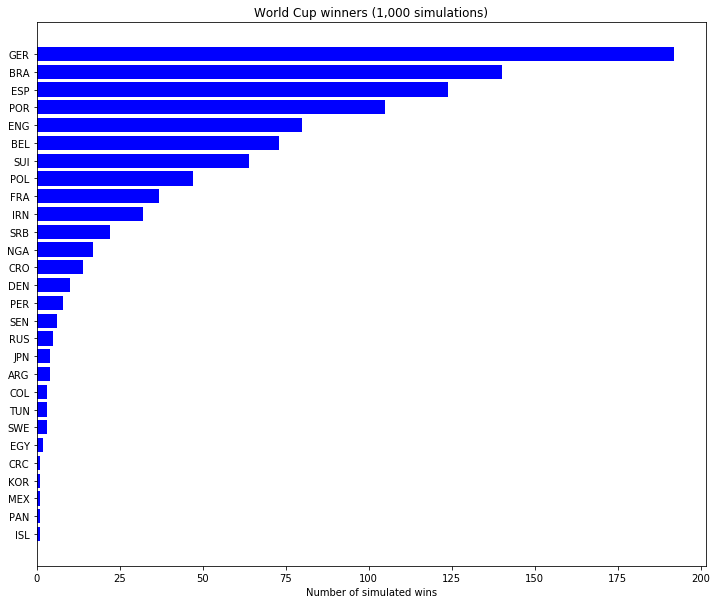

In [57]:
# plot simulated winner distributions
winsperteam = simresults.groupby('winner').count().reset_index()

indices = np.argsort(winsperteam['iteration'])

plt.figure(figsize=(12,10))
plt.title('World Cup winners (1,000 simulations)')
plt.barh(range(len(indices)), winsperteam['iteration'][indices], color='b', align='center')
plt.yticks(range(len(indices)), winsperteam['winner'][indices])
plt.xlabel('Number of simulated wins')
plt.show()

So Germany are favourites according to our model, followed by Brazil, Spain and Portugal, which sounds sensible (bear in mind that this doesn't take into account any of the World Cup games so far- Germany's shock defeat to Mexico and Brazil's surprise draw with Switzerland might reasonably influence our model!). But there are some surprising results, such as Switzerland being seventh favourites. Let's have a quick peek at what's going on here, remembering that goal difference over the past 10 games is a dominant feature.

In [58]:
match_features[(match_features['team1']=='SUI') | (match_features['team2']=='SUI')].tail(10)

,match_id,team1,date,team2,year,qualifier,finaltourn,outcome,last10games_win_per_x,last10games_loss_per_x,last10games_draw_per_x,last10games_gd_avg_x,last10games_opp_cc_per_x,last30games_win_per_x,last30games_loss_per_x,...,last10games_win_per_y,last10games_loss_per_y,last10games_draw_per_y,last10games_gd_avg_y,last10games_opp_cc_per_y,last30games_win_per_y,last30games_loss_per_y,last30games_draw_per_y,last30games_gd_avg_y,last30games_opp_cc_per_y,last50games_win_per_y,last50games_loss_per_y,last50games_draw_per_y,last50games_gd_avg_y,last50games_opp_cc_per_y
12556,11993,SUI,2014-07-01,ARG,2014,False,True,-1,0.6,0.2,0.2,0.5,0.978,0.533333,0.200000,...,0.6,0.1,0.3,0.8,0.968,0.633333,0.100000,0.266667,1.066667,0.968667,0.580000,0.180000,0.24000,0.720000,0.9718
12824,12509,FRA,2016-06-19,SUI,2016,False,True,0,0.6,0.2,0.2,1.1,0.963,0.500000,0.233333,...,0.6,0.2,0.2,0.5,0.978,0.533333,0.166667,0.300000,0.666667,0.967667,0.500000,0.200000,0.30000,0.600000,0.9710
12874,12610,POR,2016-09-06,SUI,2016,True,False,-2,0.5,0.2,0.3,0.1,0.963,0.533333,0.133333,...,0.5,0.2,0.3,0.4,0.978,0.500000,0.166667,0.333333,0.633333,0.967667,0.480000,0.200000,0.32000,0.580000,0.9710
12898,12658,SUI,2016-10-07,HUN,2016,True,False,1,0.5,0.2,0.3,0.4,0.978,0.500000,0.166667,...,0.3,0.4,0.3,-0.7,0.990,0.400000,0.366667,0.233333,0.033333,0.990000,0.420000,0.420000,0.16000,0.080000,0.9900
12916,12691,SUI,2016-10-10,AND,2016,True,False,1,0.5,0.2,0.3,0.4,0.977,0.500000,0.166667,...,0.0,1.0,0.0,-2.6,0.990,0.000000,0.933333,0.066667,-3.066667,0.990000,0.021277,0.914894,0.06383,-2.914894,0.9900
12945,12754,FRO,2016-11-13,SUI,2016,True,False,-2,0.1,0.7,0.2,-1.8,0.990,0.066667,0.833333,...,0.6,0.1,0.3,0.9,0.977,0.533333,0.166667,0.300000,0.633333,0.967667,0.520000,0.200000,0.28000,0.620000,0.9710
12987,12835,LVA,2017-03-25,SUI,2017,True,False,-1,0.2,0.7,0.1,-1.4,0.990,0.266667,0.566667,...,0.6,0.1,0.3,0.7,0.991,0.533333,0.166667,0.300000,0.566667,0.967667,0.540000,0.200000,0.26000,0.640000,0.9710
13013,12878,SUI,2017-06-09,FRO,2017,True,False,2,0.7,0.0,0.3,1.0,0.990,0.566667,0.166667,...,0.1,0.6,0.3,-1.5,0.990,0.066667,0.800000,0.133333,-1.900000,0.990000,0.100000,0.780000,0.12000,-1.860000,0.9904
13117,13092,HUN,2017-10-07,SUI,2017,True,False,-3,0.3,0.6,0.1,-0.5,0.990,0.433333,0.400000,...,0.9,0.0,0.1,1.8,0.990,0.633333,0.133333,0.233333,0.933333,0.972000,0.580000,0.180000,0.24000,0.820000,0.9738
13128,13113,SUI,2017-10-10,POR,2017,True,False,-2,0.9,0.1,0.0,1.6,0.990,0.633333,0.166667,...,0.8,0.0,0.2,1.8,0.949,0.633333,0.100000,0.266667,1.166667,0.958000,0.600000,0.120000,0.28000,1.100000,0.9654


Switzerland have won by an average of 1.4 goals per game in the 10 leading up to the World Cup. So their high ranking in our model makes sense in terms of the features, but this prompts some issues for us to think about in improving this model going forward:

* we should really look at models other than random forests and see what performs best.

* our 10, 30 and 50 game histories were somewhat arbitrarily chosen- are those the best representation of short-, medium- and long-termt form?

* what other features might be useful?

* most prominently given the outcome of this model, should we try to correct for strength of opposition in a more granular way than simply applying the confederation adjustment factor? Switzerland's last 10 games were mostly against European (EUFA) opponents, but some of them were weak teams like Northern Ireland, Andorra and Albania. The confederation adjustment might work well for longer histories, but the average quality of opposition over just 10 games might vary considerably even within the same. So what else could we do? Maybe work in FIFA rankings of opponents (although that data might be hard to collect for older games)?

* could we bring in information about the strength of the team selected on the day? Again, that data might be hard to collect, but we need to think about how we will allow in our predictions for additional useful information such as the injury, suspension or goal-scoring form of key players.

But at least we have a start on our World Cup modelling!